tia: 7.284244386192982
oxo: 8.854302379374468
R^2 tia: 0.9518253105661955
R^2 oxo: 0.9574427430281633


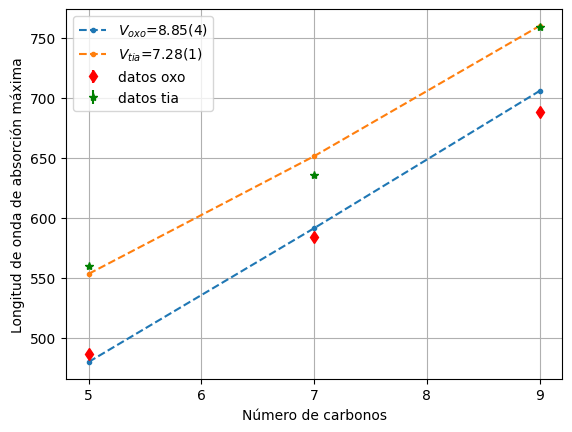

In [1]:
from numpy import pi, array, sort,linspace, tan, argmin,vectorize, arange,sqrt,std,log10
from numpy.linalg import norm
from scipy.optimize import bisect
import matplotlib.pyplot as plt
from numpy.random import normal
from math import floor

m=9.1093837015*10**(-31)
c=299792458
d=0.134*10**(-9) #https://onlinelibrary.wiley.com/doi/epdf/10.1002/qua.25996
h=6.62607015*10**(-34)
hbarra=h/(2*pi)

def formato_errores(valor,error):
  exponente_error=floor(log10(error))
  res=str(round(valor*10**(-exponente_error))*10**exponente_error)+"("+str(round(error*10**(-exponente_error)))+")"
  return res

def pozo_finito(a,V_0):

  tol=0.00001
  def rama_par(u_0):
    f=lambda x: x*tan(x)-(u_0**2-x**2)**(0.5)
    raices=[bisect(f,tol,pi/2)]
    n=1
    while n*pi+0.5*pi<u_0:
      raices.append(bisect(f,(n-1)*pi+0.5*pi+tol,n*pi+0.5*pi-tol))
      n+=1
    if f(u_0-tol)*f((n-1)*pi+0.5*pi+tol)<0:
      raices.append(bisect(f,(n-1)*pi+0.5*pi+tol,u_0-tol))
    return array(raices)

  def rama_impar(u_0):
    f=lambda x: -x/tan(x)-(u_0**2-x**2)**(0.5)
    raices=[bisect(f,tol,pi-tol)]
    n=2
    while n*pi<u_0:
      raices.append(bisect(f,(n-1)*pi+tol,n*pi-tol))
      n+=1
    if f(u_0-tol)*f((n-1)*pi+tol)<0:
      raices.append(bisect(f,(n-1)*pi+tol,u_0-tol))
    return array(raices)

  p=rama_par((m*a**2/(2*hbarra**2)*V_0)**(0.5))
  ip=rama_impar((m*a**2/(2*hbarra**2)*V_0)**(0.5))

  p=p**2*2*hbarra**2/(m*a**2)
  ip=ip**2*2*hbarra**2/(m*a**2)

  return sort(array(list(p)+list(ip)))

def f_saltos(V_0):
  s_5=pozo_finito(d*7,V_0)
  s_7=pozo_finito(d*9,V_0)
  s_9=pozo_finito(d*11,V_0)

  s_579=([s_5[4]-s_5[3],s_7[5]-s_7[4],s_9[6]-s_9[5]])
  return s_579

def f_saltos_individuales(V_0,p):
  if p==5:
    s_5=pozo_finito(d*7,V_0)
    return s_5[4]-s_5[3]
  elif p==7:
    s_7=pozo_finito(d*9,V_0)
    return s_7[5]-s_7[4]
  elif p==9:
    s_9=pozo_finito(d*11,V_0)
    return s_9[6]-s_9[5]

def proceso_total(err_oxo,err_tia,variar=False):
  long_oxo=array([486.44577812029365, 583.9266634446756, 687.7738675350618])
  long_tia=array([559.5380816786256, 635.9814064064471, 759.1669283454073])

  if variar:
    long_oxo=long_oxo+normal(0,1)
    long_tia=long_tia+normal(0,1)

  energias_tia=array(list(map(lambda x: h*c/(x*10**(-9)),long_tia)))
  energias_oxo=array(list(map(lambda x: h*c/(x*10**(-9)),long_oxo)))

  f_min_tia= lambda x: norm(f_saltos(x)-energias_tia)**2
  f_min_oxo= lambda x: norm(f_saltos(x)-energias_oxo)**2
  if variar:
    xi_tia=linspace(1.1*10**(-18),1.3*10**(-18),100)
    xi_oxo=linspace(1.2*10**(-18),1.8*10**(-18),100)
  else:
    xi_tia=linspace(1.1*10**(-18),1.3*10**(-18),1000)
    xi_oxo=linspace(1.2*10**(-18),1.8*10**(-18),1000)
  y_oxo=array(list(map(f_min_oxo,xi_oxo)))
  y_tia=array(list(map(f_min_tia,xi_tia)))

  V_0_tia=xi_tia[argmin(y_tia)]
  V_0_oxo=xi_oxo[argmin(y_oxo)]
  if variar:
    resultados_oxo.append(V_0_oxo/1.60218e-19)
    resultados_tia.append(V_0_tia/1.60218e-19)
  else:
    print('tia:',V_0_tia/1.60218e-19)
    print('oxo:',V_0_oxo/1.60218e-19)
    print("R^2 tia: "+str(1-f_min_tia(V_0_tia)/std(energias_tia)**2))
    print("R^2 oxo: "+str(1-f_min_oxo(V_0_oxo)/std(energias_oxo)**2))

    x=arange(5,10,2)
    plt.errorbar(x,long_oxo,0,fmt="rd",label="datos oxo")
    plt.errorbar(x,long_tia,0,fmt="g*",label="datos tia")
    plt.plot(x,list(map(lambda x: h*c/(x)*10**9,f_saltos(V_0_oxo))),".--",label=r"$V_{oxo}$="+formato_errores(V_0_oxo/1.60218e-19,err_oxo))
    plt.plot(x,list(map(lambda x: h*c/(x)*10**9,f_saltos(V_0_tia))),".--",label=r"$V_{tia}$="+formato_errores(V_0_tia/1.60218e-19,err_tia))

    plt.legend()
    plt.xlabel("Número de carbonos")
    plt.ylabel("Longitud de onda de absorción máxima")
    plt.xticks([5,6,7,8,9])
    plt.grid()

    plt.savefig("grafico2.png",dpi=600)

resultados_oxo=[]
resultados_tia=[]


for i in range(100):
  proceso_total(0,0,variar=True)


proceso_total(std(resultados_oxo),std(resultados_tia),variar=False)


In [ ]:
print(0.9518253105661955**(1/2))

0.9756153496979204
